<a href="https://colab.research.google.com/github/divaamahajan/logAnalysis-kafka-spark/blob/main/kafkaLogs/parquet_log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Web Server Log Analytics with Apache Spark


# Setting up Dependencies

In [2]:
!pip install spark
!pip install pyspark
!pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58747 sha256=80d36759f86ea31bd1064d2771284640be6cc7444437d954f3df98e64323e024
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=006a0cd144aa817d829ee33c5af4465425c4a50f4a1f3e8aa81793ecf417119c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

# Get the existing SparkSession
spark = SparkSession.builder.getOrCreate()

# Create SQLContext
sqlContext = SQLContext(spark)


In [4]:
spark

In [5]:
sqlContext

In [6]:
import re
import pandas as pd

## Basic Regular Expressions

In [7]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<re.Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<re.Match object; span=(25, 36), match=' in PySpark'> 25 36


# Loading and Viewing the parquet files


In [34]:
import glob
import zipfile

# Find the path of the zip file
zip_file_path = glob.glob('*.zip')[0]

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()


In [35]:
parquet_files = glob.glob('parquet/*.parquet')
parquet_files

['parquet/part-00000-88388fb2-d737-474b-abed-dee2a47e0856-c000.snappy.parquet',
 'parquet/part-00000-ef9610f0-d588-4f59-9331-bd52e4f17869-c000.snappy.parquet',
 'parquet/part-00000-d3acb701-a68a-4c88-82dc-9d7dd25d76f2-c000.snappy.parquet',
 'parquet/part-00000-9415283f-c125-4c12-8be2-bae552aa8192-c000.snappy.parquet',
 'parquet/part-00000-6f96cad8-1d37-46b4-b67e-76d0c9ea81a7-c000.snappy.parquet',
 'parquet/part-00000-0c822a6e-970f-4e1a-9a1d-cd598193bce5-c000.snappy.parquet',
 'parquet/part-00000-d794c4f4-4ec8-435d-81d9-c29062bc1a5b-c000.snappy.parquet',
 'parquet/part-00000-d9a79b41-c904-4722-a1b1-2b5f0b55eb68-c000.snappy.parquet']

### Metadata of dataframe

In [63]:
# Read the Parquet files into a DataFrame
logs_df = spark.read.parquet(*parquet_files)

# Show the first 10 rows of the DataFrame
logs_df.show(10, truncate=False)


+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|ip_address     |year|month|day|hour|minute|method|endpoint                                                                         |http_version|response_code|bytes|
+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|75.77.74.150   |2118|Dec  |26 |    |      |GET   |/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm|1.0         |200          |5302 |
|176.120.174.1  |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm|1.0         |500          |34727|
|162.200.34.120 |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm         |1.0         |403          |25428

In [64]:
logs_df.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- response_code: string (nullable = true)
 |-- bytes: string (nullable = true)



In [65]:
type(logs_df)

pyspark.sql.dataframe.DataFrame

Convert a dataframe to an RDD if needed

In [66]:
logs_df_rdd = logs_df.rdd
type(logs_df_rdd)

pyspark.rdd.RDD

### Viewing sample data in our dataframe

In [40]:
logs_df.show(10, truncate=False)

+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|ip_address     |year|month|day|hour|minute|method|endpoint                                                                         |http_version|response_code|bytes|
+---------------+----+-----+---+----+------+------+---------------------------------------------------------------------------------+------------+-------------+-----+
|75.77.74.150   |2118|Dec  |26 |    |      |GET   |/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm|1.0         |200          |5302 |
|176.120.174.1  |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm|1.0         |500          |34727|
|162.200.34.120 |2118|Dec  |26 |    |      |POST  |/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm         |1.0         |403          |25428

In [41]:
logs_df_rdd.take(10)

[Row(ip_address='75.77.74.150', year='2118', month='Dec', day='26', hour='', minute='', method='GET', endpoint='/Archives/edgar/data/0001518715/000151871522000011/0001518715-22-000011-index.htm', http_version='1.0', response_code='200', bytes='5302'),
 Row(ip_address='176.120.174.1', year='2118', month='Dec', day='26', hour='', minute='', method='POST', endpoint='/Archives/edgar/data/0001411207/000156459021052445/0001564590-21-052445-index.htm', http_version='1.0', response_code='500', bytes='34727'),
 Row(ip_address='162.200.34.120', year='2118', month='Dec', day='26', hour='', minute='', method='POST', endpoint='/Archives/edgar/data/0000101382/000156459022006546/umbf-10k_20211231.htm', http_version='1.0', response_code='403', bytes='25428'),
 Row(ip_address='133.224.84.239', year='2118', month='Dec', day='26', hour='', minute='', method='GET', endpoint='/Archives/edgar/data/0001179929/000117992922000054/a2022definitiveproxy.htm', http_version='1.0', response_code='304', bytes='27248'

# Data Wrangling
Clean and parse dataset to extract structured attributes with meaningful information from each log message.


In [42]:
print((logs_df.count(), len(logs_df.columns)))

(120001, 11)


## Adding days of the week

In [71]:
from pyspark.sql.functions import col, concat, date_format, lit, to_date, when

# Convert month column to numeric format
month_mapping = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

logs_df = logs_df.withColumn('month_num', lit(None).cast('string'))

for month, month_num in month_mapping.items():
    logs_df = logs_df.withColumn('month_num', 
                                 when(col('month') == month, month_num).otherwise(col('month_num')))

# Add the day_of_week column
logs_df = logs_df.withColumn('date_str', concat(col('year'), lit('-'), col('month_num'), lit('-'), col('day')))
logs_df = logs_df.withColumn('date', to_date(logs_df['date_str'], 'yyyy-MM-dd'))
logs_df = logs_df.withColumn('day_of_week', date_format(logs_df['date'], 'EEEE'))

# Drop the date_str column
logs_df = logs_df.drop('date_str')

# Show the updated DataFrame
logs_df.show()


+---------------+----+-----+---+----+------+------+--------------------+------------+-------------+-----+---------+-----------+----------+
|     ip_address|year|month|day|hour|minute|method|            endpoint|http_version|response_code|bytes|month_num|day_of_week|      date|
+---------------+----+-----+---+----+------+------+--------------------+------------+-------------+-----+---------+-----------+----------+
|   75.77.74.150|2118|  Dec| 26|    |      |   GET|/Archives/edgar/d...|         1.0|          200| 5302|       12|     Monday|2118-12-26|
|  176.120.174.1|2118|  Dec| 26|    |      |  POST|/Archives/edgar/d...|         1.0|          500|34727|       12|     Monday|2118-12-26|
| 162.200.34.120|2118|  Dec| 26|    |      |  POST|/Archives/edgar/d...|         1.0|          403|25428|       12|     Monday|2118-12-26|
| 133.224.84.239|2118|  Dec| 26|    |      |   GET|/Archives/edgar/d...|         1.0|          304|27248|       12|     Monday|2118-12-26|
| 211.239.196.64|2118|  Dec

## Finding Missing Values

__Note:__ :  _big dataset_ is residing on disk which can potentially be present in multiple nodes in a spark cluster.

In [75]:
logs_df.columns

['ip_address',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'method',
 'endpoint',
 'http_version',
 'response_code',
 'bytes',
 'month_num',
 'day_of_week',
 'date']

In [76]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|ip_address|year|month|day|hour|minute|method|endpoint|http_version|response_code|bytes|month_num|day_of_week|date|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|         0|   0|    0|  0|   0|     0|     0|       0|           0|            0|    0|        1|          1|   1|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+



In [77]:
null_month_num_rows = logs_df.filter(logs_df['month_num'].isNull())
null_month_num_rows.show()

+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|ip_address|year|month|day|hour|minute|method|endpoint|http_version|response_code|bytes|month_num|day_of_week|date|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+
|          |    |     |   |    |      |      |        |            |             |     |     null|       null|null|
+----------+----+-----+---+----+------+------+--------+------------+-------------+-----+---------+-----------+----+



In [78]:
logs_df = logs_df.dropna(subset=['month_num'])


In [79]:
logs_df.select('year').distinct().rdd.flatMap(lambda x: x).collect()


['2118']

In [80]:
logs_df.printSchema()

root
 |-- ip_address: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- http_version: string (nullable = true)
 |-- response_code: string (nullable = true)
 |-- bytes: string (nullable = true)
 |-- month_num: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- date: date (nullable = true)



In [81]:
logs_df.limit(5).toPandas()

,ip_address,year,month,day,hour,minute,method,endpoint,http_version,response_code,bytes,month_num,day_of_week,date
0,75.77.74.150,2118,Dec,26,,,GET,/Archives/edgar/data/0001518715/00015187152200...,1.0,200,5302,12,Monday,2118-12-26
1,176.120.174.1,2118,Dec,26,,,POST,/Archives/edgar/data/0001411207/00015645902105...,1.0,500,34727,12,Monday,2118-12-26
2,162.200.34.120,2118,Dec,26,,,POST,/Archives/edgar/data/0000101382/00015645902200...,1.0,403,25428,12,Monday,2118-12-26
3,133.224.84.239,2118,Dec,26,,,GET,/Archives/edgar/data/0001179929/00011799292200...,1.0,304,27248,12,Monday,2118-12-26
4,211.239.196.64,2118,Dec,26,,,GET,/Archives/edgar/data/0000081391/00009324711200...,1.0,200,32034,12,Monday,2118-12-26


Let's now cache `logs_df` since we will be using it extensively for our data analysis section in the next part!

In [82]:
logs_df.cache()

DataFrame[ip_address: string, year: string, month: string, day: string, hour: string, minute: string, method: string, endpoint: string, http_version: string, response_code: string, bytes: string, month_num: string, day_of_week: string, date: date]

# Data Analysis on Web Logs (EDA)

Exploratory data analysis (EDA)


## Byte Size Statistics

In [84]:
byte_size_summary_df = logs_df.describe(['bytes'])
byte_size_summary_df.toPandas()

,summary,bytes
0,count,120000
1,mean,29975.596575
2,stddev,17334.347684501685
3,min,1
4,max,9998


In [86]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['bytes']).alias('min_byte_size'),
             F.max(logs_df['bytes']).alias('max_byte_size'),
             F.mean(logs_df['bytes']).alias('mean_byte_size'),
             F.stddev(logs_df['bytes']).alias('std_byte_size'),
             F.count(logs_df['bytes']).alias('count_byte_size'))
        .toPandas())

,min_byte_size,max_byte_size,mean_byte_size,std_byte_size,count_byte_size
0,1,9998,29975.596575,17334.347685,120000


## HTTP Response Code Analysis


In [87]:
response_freq_df = (logs_df
                     .groupBy('response_code')
                     .count()
                     .sort('response_code')
                     .cache())

In [88]:
print('Total distinct HTTP Response Codes:', response_freq_df.count())

Total distinct HTTP Response Codes: 7


In [89]:
status_freq_pd_df = (response_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,response_code,count
0,200,17284
4,404,17173
3,403,17135
5,500,17133
2,304,17131
6,502,17079
1,303,17065


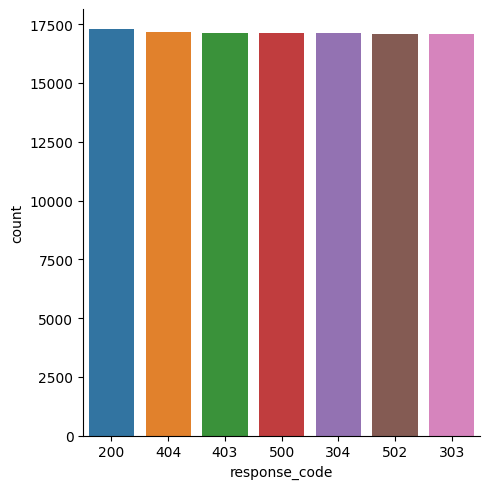

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='response_code', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['response_code'])

The resulting DataFrame log_freq_df will have an additional column named `log(count)`, which contains the logarithm of the values in the `count` column ie. the logarithm (base 'e') of the count value. The purpose of applying the logarithm function in this case might be to transform the count values into a different scale or to normalize them for analysis or visualization purposes.



In [91]:
log_freq_df = response_freq_df.withColumn('log(count)', F.log(response_freq_df['count']))
log_freq_df.show()

+-------------+-----+-----------------+
|response_code|count|       log(count)|
+-------------+-----+-----------------+
|          200|17284|9.757536497051824|
|          303|17065|9.744784861340808|
|          304|17131|9.748644966730458|
|          403|17135| 9.74887843430871|
|          404|17173|9.751093661983862|
|          500|17133|9.748761707332973|
|          502|17079|9.745604917619191|
+-------------+-----+-----------------+



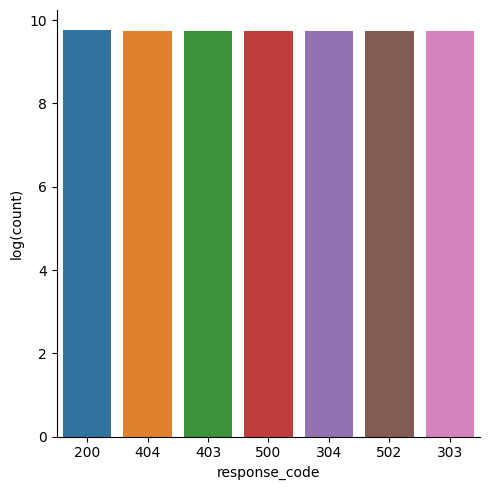

In [92]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='response_code', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['response_code'])

By examining the data, we can make the following observations:

- The most frequent response code is '200' with a count of 17,284. Its corresponding logarithm is approximately 9.7575.
- Other response codes like '303', '304', '403', '404', '500', and '502' also have high counts and their respective logarithm values.

## 200 Response Codes Analysis

### Counting 200 Response Codes


In [121]:
ok_df = logs_df.filter(logs_df["response_code"] == 200).cache()
print(('Total 200 responses: {}').format(ok_df.count()))

Total 200 responses: 17284


### Listing the Top Twenty 200 Response Code Endpoints


In [122]:
endpoints_200_count_df = (ok_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_200_count_df.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+
|endpoint                                                                               |count|
+---------------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001168220/000116822009000023/form10k-a_123108.htm                |152  |
|/Archives/edgar/data/0001091667/000109166722000024/chtr-20211231.htm                   |141  |
|/Archives/edgar/data/27673/0001104659-12-037692.txt                                    |141  |
|/Archives/edgar/data/0000004281/000119312517062657/R96.htm                             |139  |
|/Archives/edgar/data/0000205007/000114554923015369/0001145549-23-015369.txt            |137  |
|/Archives/edgar/data/1826671/000121390023023294/0001213900-23-023294.txt               |137  |
|/Archives/edgar/data/0001760283/000121390021017155/s131124_10k.htm                     |136  |
|/Archives/edgar/data/925548/00009215300

### Listing the Top Twenty 200 Response Code ip_addresss


In [123]:
ip_addresss_200_count_df = (ok_df
                          .groupBy("ip_address")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

ip_addresss_200_count_df.show(truncate=False)

+---------------+-----+
|ip_address     |count|
+---------------+-----+
|200.235.72.159 |1    |
|181.62.14.189  |1    |
|37.3.220.78    |1    |
|119.140.89.180 |1    |
|84.106.114.163 |1    |
|169.65.170.125 |1    |
|116.15.217.208 |1    |
|55.58.138.209  |1    |
|37.197.57.106  |1    |
|104.0.40.147   |1    |
|66.245.41.183  |1    |
|160.101.108.92 |1    |
|33.127.106.105 |1    |
|28.89.134.48   |1    |
|131.231.171.173|1    |
|192.217.108.83 |1    |
|58.179.245.191 |1    |
|165.110.95.126 |1    |
|12.23.148.181  |1    |
|58.205.152.141 |1    |
+---------------+-----+



### 200 OK per Day


In [124]:
errors_by_date_sorted_df = (ok_df
                                .groupBy("date")
                                .count()
                                .sort("date"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,date,count
0,2118-12-26,17284


All 200 OK codes fall on 2118-Dec-26 

### Days of the Week with 200 Status Codes

In [125]:
from pyspark.sql.functions import col

week_counts_df = ok_df.groupBy('day_of_week').count().orderBy(col('count').asc())
week_counts_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|     Monday|17284|
+-----------+-----+



### Hourly 200 Errors

In [126]:
hourly_avg_errors_sorted_df = (ok_df
                                   .groupBy('hour')
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()
hourly_avg_errors_sorted_pd_df

,hour,count
0,,17284


All 200 OK fall at midnight

## 404 Response Codes Analysis

### Counting 404 Response Codes


In [ ]:
not_found_df = logs_df.filter(logs_df["response_code"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 17173


### Listing the Top Twenty 404 Response Code Endpoints


In [ ]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+---------------------------------------------------------------------------------+-----+
|endpoint                                                                         |count|
+---------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g24.jpg          |141  |
|/Archives/edgar/data/1390098/000121390023023295/0001213900-23-023295.txt         |139  |
|/Archives/edgar/data/0001002638/000100263815000016/0001002638-15-000016-index.htm|139  |
|/Archives/edgar/data/0001260125/000114420419015093/tv516458_10k.htm              |138  |
|/Archives/edgar/data/0001724128/000121390021017151/s131120_10k.htm               |138  |
|/Archives/edgar/data/0001798682/000121390021017167/s131143_10k.htm               |138  |
|/Archives/edgar/data/27419/0001104659-12-037689.txt                              |138  |
|/Archives/edgar/data/0000205007/000114554923005581/primary_doc.xml               |136  |
|/Archives

### Listing the Top Twenty 404 Response Code ip_addresss


In [ ]:
ip_addresss_404_count_df = (not_found_df
                          .groupBy("ip_address")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

ip_addresss_404_count_df.show(truncate=False)

+--------------+-----+
|ip_address    |count|
+--------------+-----+
|211.192.19.243|1    |
|203.239.62.214|1    |
|57.99.6.85    |1    |
|170.110.43.62 |1    |
|113.168.71.233|1    |
|17.124.63.123 |1    |
|166.80.39.27  |1    |
|92.213.198.148|1    |
|221.135.7.230 |1    |
|73.69.108.205 |1    |
|198.64.95.135 |1    |
|52.252.133.84 |1    |
|130.87.117.238|1    |
|84.87.158.202 |1    |
|57.111.250.153|1    |
|209.225.219.7 |1    |
|95.78.148.135 |1    |
|60.41.3.141   |1    |
|60.240.27.28  |1    |
|107.255.13.99 |1    |
+--------------+-----+



### 404 Errors per Day


In [ ]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy("date")
                                .count()
                                .sort("date"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,date,count
0,2118-12-26,17173


All 404 errors fall on 2118-Dec-26 

### Days of the Week with 404 Status Codes

In [ ]:
from pyspark.sql.functions import col

week_counts_df = not_found_df.groupBy('day_of_week').count().orderBy(col('count').asc())
week_counts_df.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|     Monday|17173|
+-----------+-----+



### Hourly 404 Errors

In [ ]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy('hour')
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()
hourly_avg_errors_sorted_pd_df

,hour,count
0,,17173


All 404 errors fall at midnight

## IP Address Analysis

### Analyzing Frequent IP Address
Get the count of total accesses by each `ip_address` and then sort by the counts and display only the top ten most frequent ip_addresss.

In [93]:
ip_address_sum_df =(logs_df
               .groupBy('ip_address')
               .count()
               .sort('count', ascending=False).limit(10))

ip_address_sum_df.show(truncate=False)

+---------------+-----+
|ip_address     |count|
+---------------+-----+
|136.107.117.116|2    |
|55.135.36.93   |2    |
|163.218.128.230|1    |
|99.46.28.107   |1    |
|164.21.58.62   |1    |
|211.192.19.243 |1    |
|21.51.229.253  |1    |
|3.20.196.136   |1    |
|55.134.128.41  |1    |
|200.235.72.159 |1    |
+---------------+-----+



### Total number of Unique ip_addresss

In [ ]:
unique_ip_address_count = (logs_df
                     .select('ip_address')
                     .distinct()
                     .count())
unique_ip_address_count

119998

### Number of Unique Daily ip_addresss


In [ ]:
ip_address_day_distinct_df = logs_df.select(logs_df.ip_address,'day').dropDuplicates()
ip_address_day_distinct_df.show(5, truncate=False)

+--------------+---+
|ip_address    |day|
+--------------+---+
|155.58.151.29 |26 |
|163.82.174.139|26 |
|165.179.232.65|26 |
|193.21.255.115|26 |
|108.76.56.192 |26 |
+--------------+---+
only showing top 5 rows



**`daily_unique_ip_addresss_df`**

A DataFrame with two columns:

| column  | explanation                                        |
| ------- | -------------------------------------------------- |
| `day`   | the day of the month                               |
| `count` | the number of unique requesting ip_addresss for that day |

In [ ]:
dir(pd.options)

['compute', 'display', 'io', 'mode', 'plotting', 'styler']

In [ ]:
def_mr = pd.options.display.max_rows
pd.options.display.max_rows = 10
daily_ip_addresss_df = (ip_address_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_ip_addresss_df = daily_ip_addresss_df.toPandas()
daily_ip_addresss_df

,day,count
0,26,119998


## EndPoints Analysis

### Display the Top 20 Frequent EndPoints
The number of hits to endpoints (URIs) in the log. 
- Group by the `endpoint` column, aggregate by count, 
- sort in descending order like the previous part.

In [95]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [96]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/Archives/edgar/data/000132756719000032/000132...,863
1,/Archives/edgar/data/0001704304/00009296381900...,861
2,/Archives/edgar/data/0001203957/00011931251022...,853
3,/Archives/edgar/data/1356093/00008843000800001...,853
4,/Archives/edgar/data/0001260125/00011442041901...,852
5,/Archives/edgar/data/0001179929/00011799292300...,851
6,/Archives/edgar/data/1319616/00012091911901959...,850
7,/Archives/edgar/data/0001608293/00011931251422...,850
8,/Archives/edgar/data/0000318833/00003542042100...,847
9,/Archives/edgar/data/1390098/00012139002302329...,846


### Top 10 Error Endpoints
Sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

In [97]:
not200_df = (logs_df
               .filter(logs_df['response_code'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [98]:
error_endpoints_freq_df.show(truncate=False)

+---------------------------------------------------------------------------------+-----+
|endpoint                                                                         |count|
+---------------------------------------------------------------------------------+-----+
|/Archives/edgar/data/0001704304/000092963819000386/form10k.htm                   |746  |
|/Archives/edgar/data/1356093/000088430008000018/0000884300-08-000018.txt         |743  |
|/Archives/edgar/data/000132756719000032/0001327567-19-000032-index.html          |739  |
|/Archives/edgar/data/0000318833/000035420421000574/SEC13G_Filing.htm             |736  |
|/Archives/edgar/data/0001203957/000119312510223947/0001193125-10-223947-index.htm|734  |
|/Archives/edgar/data/0001591698/000104746914000931/a2218171zs-1a.htm             |732  |
|/Archives/edgar/data/0001179929/000117992923000043/moh-20230320_g29.jpg          |732  |
|/Archives/edgar/data/1319616/000120919119019599/0001209191-19-019599-index.htm   |730  |
|/Archives

### Endpoint that received the highest number of invocations on a specific day of the week

Calculating the count of invocations for each unique combination of day of the week and endpoint

In [ ]:
from pyspark.sql.functions import date_format, count, max
# Group the data by day of the week and endpoint, and count the number of invocations
grouped_df = logs_df.groupBy('day_of_week', 'endpoint').agg(count('*').alias('invocations'))
grouped_df.show(10, truncate=True)


+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|     Monday|/Archives/edgar/d...|        811|
|     Monday|/Archives/edgar/d...|        800|
|     Monday|/Archives/edgar/d...|        850|
|     Monday|/Archives/edgar/d...|        805|
|     Monday|/Archives/edgar/d...|        758|
|     Monday|/Archives/edgar/d...|        806|
|     Monday|/Archives/edgar/d...|        815|
|     Monday|/Archives/edgar/d...|        787|
|     Monday|/Archives/edgar/d...|        786|
|     Monday|/Archives/edgar/d...|        782|
+-----------+--------------------+-----------+
only showing top 10 rows



Select the highest count for each unique day of week

In [ ]:
# Avoids the join operation. 
# Utilize window functions to rank the rows and directly filter the rows with the highest invocations.
# This can be advantageous when dealing with large datasets since it avoids the overhead of the join operation.

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Add a row number column based on the invocations in descending order for each day_of_week
windowSpec = Window.partitionBy('day_of_week').orderBy(grouped_df['invocations'].desc())
ranked_df = grouped_df.withColumn('rank', row_number().over(windowSpec))

# Filter the ranked DataFrame to retain only the rows with rank 1 (highest invocations)
max_invocations_df = ranked_df.filter(ranked_df['rank'] == 1)

# Summarize the results and display the day_of_week, endpoint, and invocations with max invocations
max_invocations_df.select('day_of_week', 'endpoint', 'invocations').show()

+-----------+--------------------+-----------+
|day_of_week|            endpoint|invocations|
+-----------+--------------------+-----------+
|     Monday|/Archives/edgar/d...|        863|
+-----------+--------------------+-----------+



All invocations fall on a Monday

## Method Analysis

### Analyzing Frequent Methods

In [129]:
methods_sum_df =(logs_df
               .groupBy('method')
               .count()
               .sort('count', ascending=False))

methods_sum_df.show(truncate=False)

+------+-----+
|method|count|
+------+-----+
|DELETE|30074|
|POST  |30067|
|GET   |29957|
|PUT   |29902|
+------+-----+



<ipython-input-134-dbaf134bd0dc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(methods, rotation=45)


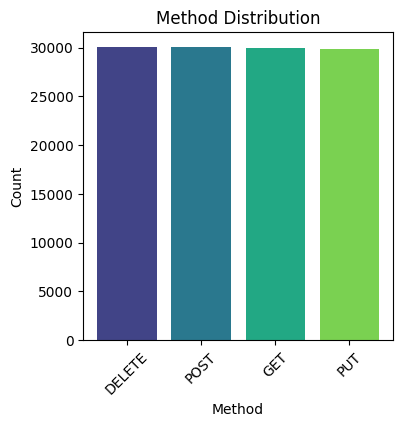

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the method names and counts from the DataFrame
methods = methods_sum_df.select('method').rdd.flatMap(lambda x: x).collect()
counts = methods_sum_df.select('count').rdd.flatMap(lambda x: x).collect()

# Set the color palette
colors = sns.color_palette('viridis', len(methods))

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(4, 4))

# Create a bar plot with colors
ax.bar(methods, counts, color=colors)

# Set the labels and title
ax.set_xlabel('Method')
ax.set_ylabel('Count')
ax.set_title('Method Distribution')

# Rotate the x-axis labels
ax.set_xticklabels(methods, rotation=45)

# Display the plot
plt.show()


### Methods to Response Codes

In [141]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('response_code', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+-------------+------+-----+
|response_code|method|count|
+-------------+------+-----+
|502          |DELETE|4265 |
|200          |GET   |4359 |
|403          |GET   |4336 |
|403          |DELETE|4349 |
|404          |PUT   |4339 |
|303          |GET   |4237 |
|200          |PUT   |4295 |
|502          |PUT   |4334 |
|502          |POST  |4298 |
|304          |POST  |4277 |
|404          |GET   |4158 |
|304          |GET   |4327 |
|502          |GET   |4182 |
|200          |DELETE|4383 |
|303          |POST  |4281 |
|404          |DELETE|4280 |
|303          |PUT   |4268 |
|500          |POST  |4278 |
|304          |DELETE|4275 |
|304          |PUT   |4252 |
+-------------+------+-----+
only showing top 20 rows



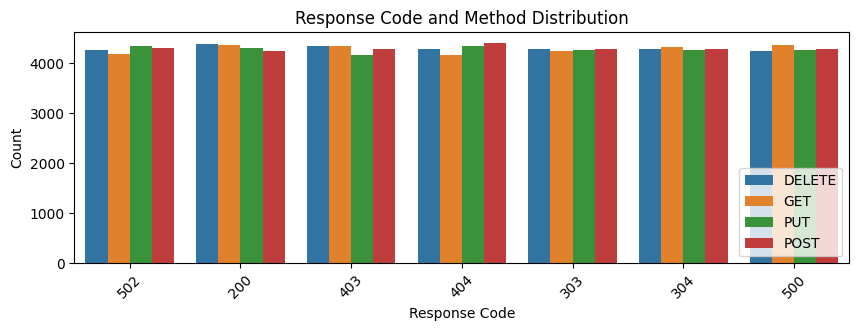

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the response_code, method, and counts from the grouped DataFrame
response_codes = grouped_df.select('response_code').rdd.flatMap(lambda x: x).collect()
methods = grouped_df.select('method').rdd.flatMap(lambda x: x).collect()
counts = grouped_df.select('count').rdd.flatMap(lambda x: x).collect()

# Create the color palette
colors = sns.color_palette('tab10', len(response_codes))

# Set the figure size
plt.figure(figsize=(10, 3))

# Create a bar plot with clustered bars and colored by response_code
sns.barplot(x=response_codes, y=counts, hue=methods, palette=colors)

# Set labels and title
plt.xlabel('Response Code')
plt.ylabel('Count')
plt.title('Response Code and Method Distribution')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Place the legend in the bottom right corner
plt.legend(loc='lower right')

# Show the plot
plt.show()


### Methods to IP Address

In [154]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('ip_address', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+---------------+------+-----+
|ip_address     |method|count|
+---------------+------+-----+
|130.72.85.37   |POST  |1    |
|28.164.235.25  |PUT   |1    |
|138.101.149.103|PUT   |1    |
|4.142.129.56   |GET   |1    |
|49.139.214.148 |GET   |1    |
|86.245.110.248 |GET   |1    |
|99.8.131.217   |GET   |1    |
|12.57.175.101  |DELETE|1    |
|102.208.14.68  |DELETE|1    |
|70.156.139.188 |PUT   |1    |
|5.4.119.82     |GET   |1    |
|77.201.220.118 |POST  |1    |
|24.48.77.112   |DELETE|1    |
|19.7.210.73    |GET   |1    |
|35.163.158.163 |GET   |1    |
|42.141.171.167 |POST  |1    |
|150.2.243.56   |PUT   |1    |
|202.97.35.233  |POST  |1    |
|11.50.12.216   |POST  |1    |
|57.174.205.134 |DELETE|1    |
+---------------+------+-----+
only showing top 20 rows



### Methods to Endpoints

In [157]:
from pyspark.sql import functions as F

# Group by response_code and method, and count the occurrences
grouped_df = logs_df.groupBy('endpoint', 'method').count()

# Show the grouped DataFrame
grouped_df.show(truncate=False)


+---------------------------------------------------------------------------------+------+-----+
|endpoint                                                                         |method|count|
+---------------------------------------------------------------------------------+------+-----+
|/Archives/edgar/data/0001439124/000129281422000788/                              |GET   |198  |
|/Archives/edgar/data/1932485/000110465923037622/tm239175d10_absee.htm            |GET   |178  |
|/Archives/edgar/data/0001035018/000119312507272779/g47607g69u06.jpg              |DELETE|182  |
|/Archives/edgar/data/0001729361/000121390021017176/s131100_10k.htm               |GET   |211  |
|/Archives/edgar/data/0000205007/000114554923005581/0001145549-23-005581.txt      |PUT   |190  |
|/Archives/edgar/data/0000004281/000119312517062657/R98.htm                       |PUT   |192  |
|/Archives/edgar/data/0001129068/000095013122003743/narot19cabsee_0818-1508.htm   |DELETE|193  |
|/Archives/edgar/data/24104/00

## Reset the max rows displayed in pandas

In [116]:
pd.set_option('display.max_rows', def_mr)

